# U-net network for super-resolution

Import libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
!pip install einops
!pip install torchviz
from einops import rearrange, reduce
from torchviz import make_dot
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Load and prepare data

Modify Pytorch CIFAR10 Dataset to load both input images as target and downscaled images as input

In [268]:
from torchvision.datasets import CIFAR10

class CIFAR10_sres(CIFAR10):
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (img_x, img_y) where img_x is the resized image from 32 to 16
            and img_y is the original 32x32 image
        """
        img, target = self.data[index], self.targets[index]

        img = Image.fromarray(img)

        # Downscale input image
        if self.transform is not None:
            img_x = self.transform(img)

        if self.target_transform is not None:
            img_y = self.target_transform(img)

        return img_x, img_y

In [267]:
# Transformations for input images
transform = transforms.Compose(
    [transforms.Resize(16),
     transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Transformations for target/label images
target_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# batch_size
batch_size = 64

# Load train data
trainset = CIFAR10_sres(root='./data',
                   train=True,
                   download=True,
                   transform=transform,
                   target_transform=target_transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size)

# Load test data
testset = CIFAR10_sres(root='./data',
                  train=False,
                  download=True,
                  transform=transform,
                  target_transform=target_transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size)

print(f'Train data len: {len(trainset)}')
print(f'Test data len: {len(testset)}')

Files already downloaded and verified
Files already downloaded and verified
Train data len: 50000
Test data len: 10000


Visualize examples of X, y data

In [7]:
from torchvision.utils import make_grid
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

Input images:


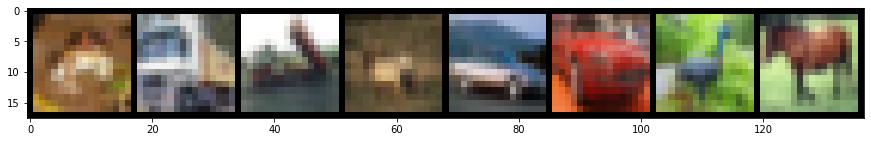

In [8]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

print("Input images:")
show(make_grid(images[:8], padding=1))

Output images:


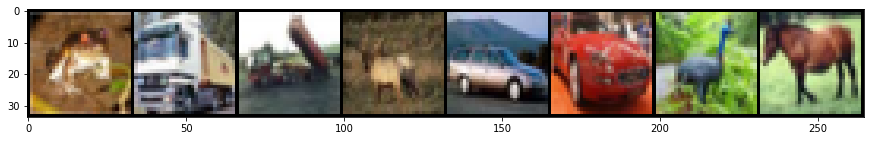

In [9]:
print("Output images:")
show(make_grid(labels[:8], padding=1))

### Network hyperparameters

In [10]:
args = {}

args["filters_per_block"] = np.array([3, 32, 64, 128])
args["num_blocks"] = len(args["filters_per_block"])
args["kernel_size"] = 3
args["dropout"] = 0.0
args["bilinear"] = False

### U-net network definition

In [253]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, kernel_size=3, dropout=0):
        super().__init__()

        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            #nn.Dropout2d(dropout)
        )

    def forward(self, x):
        return self.double_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = ConvBlock(in_channels*2, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels*2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Unet(nn.Module):
    def __init__(self, args):
        super(Unet, self).__init__()

        self.args = args

        # Encoder
        all_blocks_encoder = []
        for i in range(0, args['num_blocks']-1):
            num_filters_in = args["filters_per_block"][i]
            num_filters_out = args["filters_per_block"][i+1]

            all_blocks_encoder.append(ConvBlock(num_filters_in, num_filters_out, dropout=args['dropout']))

        self.encoder = nn.ModuleList(all_blocks_encoder)
        self.maxpool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(args["filters_per_block"][-1], args["filters_per_block"][-1])

        # Decoder
        all_blocks_decoder = []
        for i in range(1, args['num_blocks']-1):
            num_filters_in = args["filters_per_block"][-i]
            num_filters_out = args["filters_per_block"][-i-1]
            all_blocks_decoder.append(Up(num_filters_in, num_filters_out, bilinear=args["bilinear"]))
        all_blocks_decoder.append(Up(num_filters_out, num_filters_out, bilinear=args["bilinear"]))
        
        self.decoder = nn.ModuleList(all_blocks_decoder)

        # Conv from num_filters_out of last block to original image channels
        self.out_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(num_filters_out, args["filters_per_block"][0], kernel_size=self.args["kernel_size"], padding=1),
            #nn.BatchNorm2d(args["filters_per_block"][0]),
            nn.ReLU(),
            nn.Conv2d(args["filters_per_block"][0], args["filters_per_block"][0], kernel_size=self.args["kernel_size"], padding=1),
            #nn.BatchNorm2d(args["filters_per_block"][0]),
            nn.ReLU(),
        )

    def forward(self, x):

        # Encode/Down
        residual_x = []
        for block in self.encoder:
            x = block(x)
            residual_x.append(x)
            x = self.maxpool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decode/Up
        for i, block in enumerate(self.decoder):
            x = self.decoder[i](x, residual_x[-i-1])
 
        return self.out_conv(x)

### Train and test funcitons

In [238]:
#from tqdm import trange, tqdm
# tqdm fix
from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

def train(model, device, train_loader, optimizer, loss_func, epoch):

    model.train()
    status = tqdm(train_loader, total=int(len(train_loader)))
    status.set_description("Epoch {}".format(epoch))

    for batch_idx, (data, target) in enumerate(status):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func.eval(output, target)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        '''
        if batch_idx == 3:
            break
        '''
        status.set_postfix({'Loss': loss.item()})
        
    status.close(); del status


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.l1_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Custome loss

Loss based on paper "Single Image Super Resolution based on a Modified U-net with Mixed Gradient Loss" [https://arxiv.org/pdf/1911.09428.pdf]

In [242]:
class MGE():
    def __init__(self, proportion, device):
        self.proportion = proportion
        
        # Sobel operator for gradient calculation in x direction
        weights_x = torch.tensor([[-1., -2., -1.],
                                  [0., 0., 0.],
                                  [1., 2., 1.]], requires_grad=False)
        self.kernel_x = weights_x.view(1, 1, 3, 3).repeat(1, 3, 1, 1).to(device)
        
        # Sobel operator for gradient calculation in y direction
        weights_y = torch.tensor([[-1., 0., 1.],
                                  [-2., 0., 2.],
                                  [-1., 0., 1.]], requires_grad=False)
        self.kernel_y = weights_y.view(1, 1, 3, 3).repeat(1, 3, 1, 1).to(device)

    def eval(self, output, target):

        image_mse_loss = torch.mean((output - target)**2)
        
        output_grad_x = F.conv2d(output, self.kernel_x)
        output_grad_y = F.conv2d(output, self.kernel_y)
        output_grad_sqrt_sum = torch.sqrt(torch.square(output_grad_x) + torch.square(output_grad_y) + 1e-8)
        
        target_grad_x = F.conv2d(target, self.kernel_x)
        target_grad_y = F.conv2d(target, self.kernel_y)
        target_grad_sqrt_sum = torch.sqrt(torch.square(target_grad_x) + torch.square(target_grad_y) + 1e-8)
        
        grad_mse_loss = torch.mean((output_grad_sqrt_sum - target_grad_sqrt_sum)**2)
        
        return image_mse_loss + self.proportion*grad_mse_loss

In [233]:
def mge_loss(output, target, tau):
    
    # Sobel operator for gradient calculation in x direction
    weights_x = torch.tensor([[-1., -2., -1.],
                                      [0., 0., 0.],
                                      [1., 2., 1.]], requires_grad=False)
    kernel_x = weights_x.view(1, 1, 3, 3).repeat(1, 3, 1, 1).to(device)
        
    # Sobel operator for gradient calculation in y direction
    weights_y = torch.tensor([[-1., 0., 1.],
                                      [-2., 0., 2.],
                                      [-1., 0., 1.]], requires_grad=False)
    kernel_y = weights_y.view(1, 1, 3, 3).repeat(1, 3, 1, 1).to(device)
    
    #image_mse_loss = F.mse_loss(output, target)
    image_mse_loss = torch.mean((output - target)**2)
    
    output_grad_x = F.conv2d(output, kernel_x)
    output_grad_y = F.conv2d(output, kernel_y)
    output_grad_sqrt_sum = torch.sqrt(torch.square(output_grad_x) + torch.square(output_grad_y) + 1e-8)
        
    target_grad_x = F.conv2d(target, kernel_x)
    target_grad_y = F.conv2d(target, kernel_y)
    target_grad_sqrt_sum = torch.sqrt(torch.square(target_grad_x) + torch.square(target_grad_y) + 1e-8)
        
    #grad_mse_loss = F.mse_loss(output_grad_sqrt_sum, target_grad_sqrt_sum)
    grad_mse_loss = torch.mean((output_grad_sqrt_sum - target_grad_sqrt_sum)**2)

    return image_mse_loss + tau*grad_mse_loss

### Cuda or cpu setup

In [154]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(2)
device = torch.device("cuda" if use_cuda else "cpu")

### Create model, optimizer and train

In [265]:
model = Unet(args).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-6)
loss_func = MGE(0.001, device)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
epochs = 10

In [ ]:
for epoch in range(1, epochs+1):
    train(model, device, trainloader, optimizer, loss_func, epoch)
    scheduler.step()

Epoch 3:  81%|████████▏ | 636/782 [00:17<00:04, 36.03it/s, Loss=0.175]

### Visualize prediction result

In [256]:
model.eval()
num_imgs = 8

data_iter = iter(testloader)
images, labels = next(data_iter)
X_test = images[:num_imgs]
Y_test = labels[:num_imgs]

Input images:


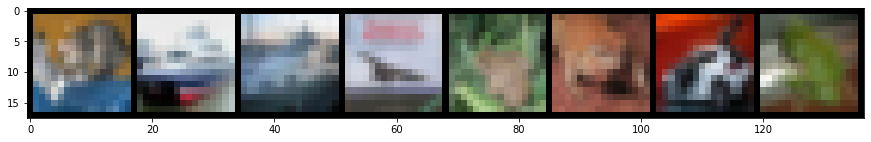

In [250]:
print("Input images:")
show(make_grid(X_test, padding=1))

Output images:


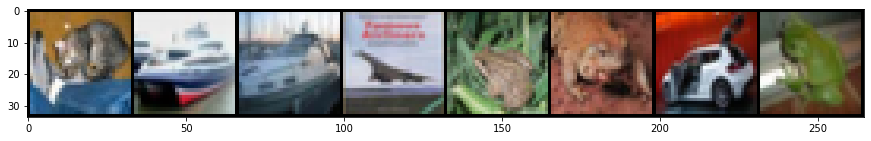

In [251]:
print("Output images:")
show(make_grid(Y_test, padding=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted images:


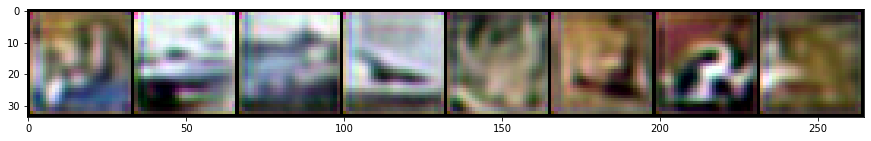

In [262]:
print("Predicted images:")
prediction = model(X_test.to(device))
prediction = prediction.cpu().detach()
show(make_grid(prediction, padding=1))